C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_ivp\ivp.py:616: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  solver = method(fun, t0, y0, tf, vectorized=vectorized, **options)


Elapsed time for RK23: 0.11098170280456543 seconds
Elapsed time for RK45: 0.03398895263671875 seconds
Elapsed time for Radau: 0.4201791286468506 seconds
Elapsed time for BDF: 0.2781045436859131 seconds
Elapsed time for LSODA: 0.09901237487792969 seconds


C:\Users\jorda\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\scipy\integrate\_ivp\rk.py:505: UserWarning: The following arguments have no effect for a chosen solver: `min_step`.
  super().__init__(fun, t0, y0, t_bound, max_step, rtol, atol,


Elapsed time for DOP853: 0.4176502227783203 seconds


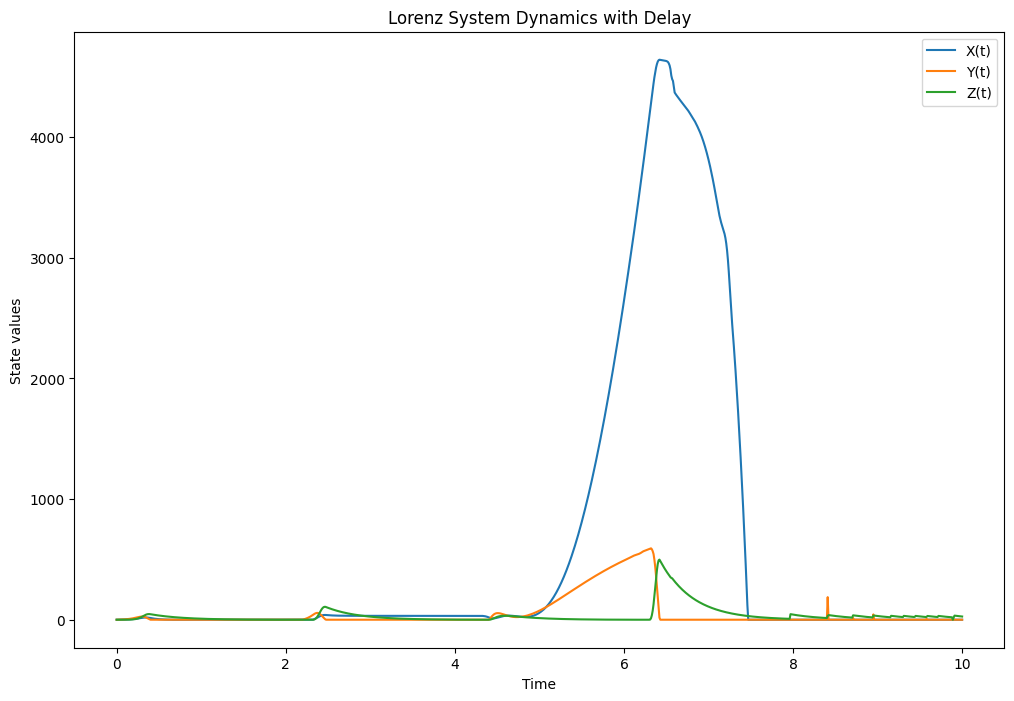

In [3]:
# Import required packages
import numpy as np
from scipy.integrate import solve_ivp
import time

# Linear interpolation function
def LinearDelay(Y, state, t):
    t_delay = max(0, t)
    L2 = np.searchsorted(Y.history[:, 0], t_delay, side='left')
    L1 = L2 - 1

    Y1 = Y.history[L1, state + 1]
    t1 = Y.history[L1, 0]
    Y2 = Y.history[L2, state + 1]
    t2 = Y.history[L2, 0]

    state_delay = Y1 + (t_delay - t1) * (Y2 - Y1) / (t2 - t1)
    state_delay = np.clip(state_delay, a_min=0.0, a_max=None)
    return state_delay

class StateHistory:
    def __init__(self, init_state):
        # Initialize with time 0 and the initial state
        self.history = np.array([[0] + list(init_state)])  # ensure proper shape

    def update(self, t, y):
        new_entry = np.array([t] + list(y))
        self.history = np.vstack([self.history, new_entry])

def LorenzModel(t, y, p, state_labels, state_history):
    y = y.clip(min=0.0)
    state_history.update(t, y)

    s = dict(zip(state_labels, y))
    
    delays = [('delay_1', 'X', 2), ('delay_2', 'X', 4)]
    
    s_tau = {
        delay[0]: LinearDelay(state_history, state_labels.index(delay[1]), t - delay[2]) if t >= delay[2] else y[state_labels.index(delay[1])]
        for delay in delays
    }

    dX = p['sigma'] * (s['Y'] - s_tau['delay_1'])
    dY = s_tau['delay_1'] * (p['rho'] - s['Z']) - s['Y']
    dZ = s_tau['delay_2'] * s['Y'] - p['beta'] * s['Z']
    
    return [dX, dY, dZ]

# Function evaluation wrapper
def evalModel(funx, p, y0, tspan, state_labels, t_eval=None):
    state_history = StateHistory(y0)
    p_local = p.copy()

    methods = ['RK23', 'RK45', 'Radau', 'BDF', 'LSODA', 'DOP853']
    for method in methods:
        opts = {'rtol': 1e-2, 'atol': 1e-3, 'min_step': 1E-6}
        try:
            start_time = time.time()
            sol = solve_ivp(funx, tspan, y0, method=method, t_eval=t_eval,
                            vectorized=False, args=(p_local, state_labels, state_history), **opts)
            end_time = time.time()
            elapsed_time = end_time - start_time
            print(f"Elapsed time for {method}: {elapsed_time} seconds")
        except RuntimeError:
            print(f'Runtime error in ODE solver for {method}.')

    sol.y = sol.y.clip(min=1.0)
    return sol

# Placeholder values for demonstration
p = {"sigma": 10, "rho": 28, "beta": 8/3, "delay_1": 2, "delay_2": 4}
y0 = np.array([1, 1, 1])  # Example initial conditions
tspan = [0, 10]
state_labels = ['X', 'Y', 'Z']
t_eval = np.linspace(0, 10, 1001)

sol = evalModel(LorenzModel, p, y0, tspan, state_labels, t_eval)

import matplotlib.pyplot as plt

def plot_results(sol):
    plt.figure(figsize=(12, 8))
    plt.plot(sol.t, sol.y[0], label='X(t)')
    plt.plot(sol.t, sol.y[1], label='Y(t)')
    plt.plot(sol.t, sol.y[2], label='Z(t)')
    plt.title("Lorenz System Dynamics with Delay")
    plt.xlabel("Time")
    plt.ylabel("State values")
    plt.legend()
    plt.show()
    
plot_results(sol)